In [16]:
import os
import numpy as np

os.chdir('flowers17feats/flowers17/feats')

# Reading

append the .npy arrays into list of list (17, 80, 512)

In [17]:
master_list = []
current_list = []
count = 0

for filename in os.listdir(os.getcwd()):
    current_list.append(np.load(filename))
    count += 1
    if count == 80:
        master_list.append(current_list)
        current_list = []
        count = 0

# Train, validation, test split

split the master_list into test, validation and training sets. save into np arrays (680,512), (340,512), (340,512)

In [18]:
import random

train_list = []
validation_list = []
test_list = []

for listdata in master_list:
    random.shuffle(listdata)
    training_set, validation_set, test_set = np.array(listdata[0:40]), np.array(listdata[40:60]), np.array(listdata[60:80])
    train_list.append(training_set)
    validation_list.append(validation_set)
    test_list.append(test_set)

train_list = np.array(np.vstack(np.stack(train_list))) #(680,512)
validation_list = np.array(np.vstack(np.stack(validation_list))) #340,512
test_list = np.array(np.vstack(np.stack(test_list))) #340,512

# Why split evenly amongst the classes

This is to ensure training and testing are on the same distribution since the split is evenly distributed amongst all classes

In [4]:
np.save("train_data.npy", train_list)
np.save("validation_data.npy", validation_list)
np.save("test_data.npy", test_list)

In [19]:
os.chdir('../../..')

train_list = np.load("train_data.npy")
validation_list = np.load("validation_data.npy")
test_list = np.load("test_data.npy")

# Training code

Create 17 binary svms trained on the training data. For each of the class, set a np array (680,) of zeros with the particular class set as ones. Use probability = True for SVM to output prediction score. Append the classifiers into a clf_list 

In [20]:
import sklearn.svm as svm


def train_clf(c, train_data):

    clf_list = []
    batch = train_data.shape[0]//17
    
    for x in range(17):
        train_label = np.zeros((train_data.shape[0],))
        train_label[x*batch:(x+1)*batch] += 1
        clf = svm.SVC(C=c,probability = True, kernel='linear') #kernel = linear is equivalent to linear svm
        clf.fit(train_data, train_label)
        clf_list.append(clf)
    
    return clf_list

# Testing code

For all data in test_data, pass it through the 17 svms and see which one outputs the highest score

In [21]:
def test_clf(test_data, clf_list):
    
    correct_pred = 0
    errors = []
    batch = test_data.shape[0]//17

    for count,datapoint in enumerate(test_data):
        label = count // batch
        datapoint = np.reshape(datapoint, (1,-1))
        cmp_list = []
        for clf in clf_list:
            prob = clf.predict_proba(datapoint)
            cmp_list.append(prob[0][1])
        pred = np.argmax(np.array(cmp_list))

        correct_pred += (pred==label)
        if pred != label:
            errors.append(count)
        
    return (correct_pred/test_data.shape[0]), errors

# Finding the best c

Testing for best c in validation set

In [22]:
c_values = [0.01, 0.1, 0.1**0.5, 1, 10**0.5, 10, 100**0.5]
accuracy_list = []

for c in c_values:
    clf_list = train_clf(c, train_list)
    accuracy, errors = test_clf(validation_list, clf_list)
    accuracy_list.append(accuracy)

In [23]:
accuracy_list

[0.9117647058823529,
 0.9088235294117647,
 0.9058823529411765,
 0.9176470588235294,
 0.9029411764705882,
 0.9147058823529411,
 0.9117647058823529]

<function matplotlib.pyplot.show(*args, **kw)>

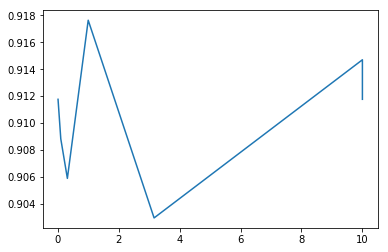

In [24]:
import matplotlib.pyplot as plt

plt.plot(c_values, accuracy_list)
plt.show

Best c is apparently 1

# Training on training and validation data with best c

In [29]:
train_list = np.split(train_list, 17)
validation_list = np.split(validation_list, 17)

AttributeError: 'list' object has no attribute 'shape'

In [30]:
new_train_list = np.array(np.vstack([np.concatenate(list(a)) for a in zip(train_list, validation_list)]))
new_train_list.shape

(1020, 512)

In [31]:
clf_list = train_clf(1, new_train_list)
accuracy, errors = test_clf(test_list, clf_list)
error_dict = {}
for error in errors:
    error_class = error // 40
    error_dict[error_class] = error

In [32]:
print (accuracy, error_dict)

0.9235294117647059 {0: 39, 1: 79, 2: 105, 3: 149, 4: 179, 5: 237, 6: 263, 7: 304}
